## Assignment 3

#### Import Required libraries

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import chess
import chess.pgn
import io
import re
import time
# import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#### Import CSV file

In [3]:
# todo: i forgor what the exact file is called, update this
CHESS_DATA_LOCATION = "data/club_games_data.csv"
# MOVIES_DATA_LOCATION = "data/movies.csv"

# load csv into a big dataframe
chess_data = pd.read_csv(CHESS_DATA_LOCATION)
print(len(chess_data))

66879


In [4]:
print(chess_data.dtypes)
# print(chess["rules"].unique())
# ['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']
# dunno if we should filter by chess only

# time control
#['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
#  '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
#  '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
#  '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
#  '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
#  '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
#  '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
#  '60+10']
# so many types of time control -_-

# time class
# ['daily' 'rapid' 'bullet' 'blitz']

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Clean data

In [5]:
# Drops rows if any value is a NaN, but data is clean so it doesn't do anything
chess_data.dropna(axis = 0, how = 'any')
# filter out alternative rules like chess960 etc
chess_data = chess_data[chess_data['rules'] == "chess"]
# remove any game that starts with rnbqkbnr cos that shows the game barely developed

# 1360 entries
chess_data = chess_data[~(chess_data['white_result'] == chess_data['black_result'])]

# if the game ends with "rnbqkbnr", that indicates a very undeveloped board,
# i.e. the game barely started so it shouldn't be counted
chess_data = chess_data[~chess_data['fen'].str.startswith("rnbqkbnr/")] # 1360 entries
counter = 0

# get id's of values to drop (so the for loop doesn't mess up )
drops = []
# preemptive index reset
chess_data = chess_data.reset_index(drop=True)
# for any in the chess data
for i in range(len(chess_data)):
    # get pgn string (final line of pgn column)
    pgn = chess_data['pgn'][i].splitlines()[-1]
    # find all entries of a move
    # i.e. "1." or "2."
    entries = re.findall("[123456789]\.", pgn)
    
    filter_n = 5
    # for the second type of pgn, detect timestamps and
    # since moves are labelled 1. 1... 2. 2..., double the filter size
    if (re.search("\{\[.{12,13}\]\}",pgn) != None):
        # i.e. "1. g4 {[%clk 47:56:02]}"
        filter_n = 10

    # if there's less than 5 moves, then delete entry
    if (len(entries) < filter_n):
        # print(pgn)
        drops.append(chess_data.index[i])
        # chess_data = chess_data.drop(chess_data.index[i])
        # chess_data = chess_data.reset_index(drop=True)

# drop every entry with a drop ID
for drop_id in drops:
    chess_data = chess_data.drop(drop_id)
chess_data = chess_data.reset_index(drop=True)

print(len(chess_data))

61911


In [6]:
print(len(chess_data[chess_data["time_class"] == "daily"]))
print(len(chess_data[chess_data["time_class"] == "rapid"]))
print(len(chess_data[chess_data["time_class"] == "bullet"]))
print(len(chess_data[chess_data["time_class"] == "blitz"]))

# Apply stratified sample, grouping by time class
chess_data_sample = chess_data.groupby('time_class', group_keys=False).apply(lambda x: x.sample(frac=0.2))

1193
12012
21536
27170


#### Import chess info
https://python-chess.readthedocs.io/en/latest/core.html#chess.Board.san


#### En Passant functions
- has_legal_en_passant() tests if en passant capturing would actually be possible on the next move.
- has_pseudo_legal_en_passant()
- has_legal_en_passant()
- is_en_passant(move: Move) Checks if the given pseudo-legal move is an en passant capture.




Use StringIO to parse games from a string. Lila Use this to apply the en passant functions to for each game???

```python
import io
pgn = io.StringIO("1. e4 e5 2. Nf3 *")
game = chess.pgn.read_game(pgn)
```

#### Logistic Regression

In [8]:
# chess_data

# empty wins and ELO difference array
wins = []
wins_split = [[] for _ in range(6)]
# diffs split
# 0 to 500 | 500 to 1k | 1k to 1.5k | 1.5k to 2k | 2k to 2.5k | 2.5k+
diffs = []
diffs_split = [[] for _ in range(6)]

min_split = [10000] * 6
max_split = [0] * 6

ranges = [500, 1000, 1500, 2000, 2500, 3000]

for i in range(len(chess_data)):
    # get the ratings of each and the results
    white = chess_data["white_rating"][i]
    black = chess_data["black_rating"][i]
    result = chess_data["white_result"][i]

    # find ELO mismatch size
    diff = white - black
    avg = (white + black) // 2
    # if white wins then append 1
    binary_result = 0
    if (result == "win"):    
        binary_result = 1
    wins.append(binary_result)
    # append the elo mismatch
    diffs.append(diff)
    
    for j in range(6):
        if avg <= ranges[j]:
            diffs_split[j].append(diff)
            wins_split[j].append(binary_result)
            if diff <= min_split[j]:
                min_split[j] = diff
            if diff >= max_split[j]:
                max_split[j] = diff

# set to numpy array to be able to do logistic regression
np_diffs = np.array(diffs).reshape(-1,1)
np_wins = np.array(wins)

# fit logistic regression
total_model = LogisticRegression().fit(np_diffs, np_wins)

split_model = []

# print(wins_split[0])

for i in range(6):
    np_diffs_split = np.array(diffs_split[i]).reshape(-1,1)
    np_wins_split = np.array(wins_split[i])
    split_model.append(LogisticRegression().fit(np_diffs_split, np_wins_split))

beta0 = total_model.intercept_[0]
beta1 = total_model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))

Beta 0: 0.07679440137376388, Beta 1: 0.010279331712464887


Text(0, 0.5, 'Win probability')

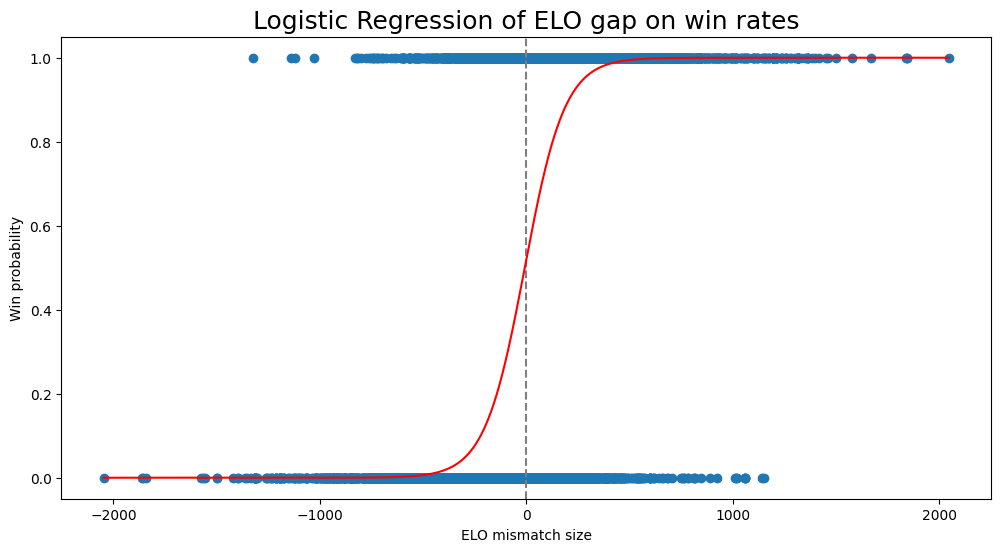

In [9]:
fig, ax1 = plt.subplots(figsize=(12,6))
# binary scatter plot
ax1.scatter(diffs, wins)

# np.arange for the range of values in the difference of ELO
x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax1.axvline(x = 0, color="gray", linestyle="dashed")

# plot logistic regression estimator
ax1.plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
ax1.set_title("Logistic Regression of ELO gap on win rates", fontsize=18)
ax1.set_xlabel("ELO mismatch size")
ax1.set_ylabel("Win probability")

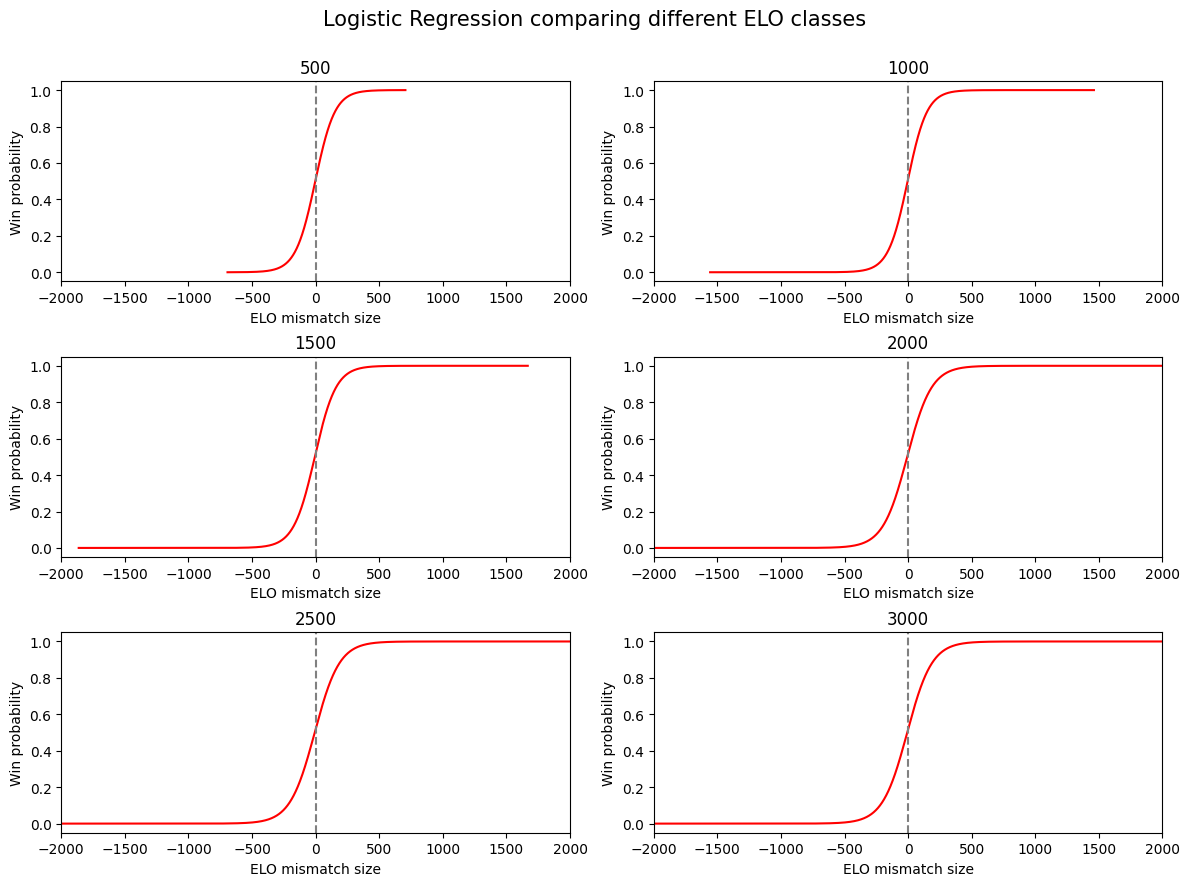

In [10]:
fig, ax2 = plt.subplots(3,2,figsize=(12,9))
# binary scatter plot

# np.arange for the range of values in the difference of ELO

# plot logistic regresion estimator

for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax2[i//2][i%2].plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
    
    ax2[i//2][i%2].axvline(x = 0, color="gray", linestyle="dashed")
    ax2[i//2][i%2].set_xlabel("ELO mismatch size")
    ax2[i//2][i%2].set_ylabel("Win probability")
    ax2[i//2][i%2].set_xlim([-2000, 2000])
    ax2[i//2][i%2].set_title(str(ranges[i]))

fig.tight_layout()
fig.suptitle("Logistic Regression comparing different ELO classes", fontsize=15)
fig.subplots_adjust(top=0.9)